# Exploratory Data Analysis
### Overview
In this crucial phase of our analysis, we embark on a journey of Exploratory Data Analysis (EDA) that focuses exclusively on the training data. <br>
Our mission is to unveil the hidden treasures and subtleties nestled within the log data, all while ensuring the utmost vigilance against any potential data leaks that could taint our insights.<br>
To navigate this uncharted territory, we have charted a course paved with a diverse array of Natural Language Processing (NLP) techniques. <br> 
These techniques serve as our guiding stars, illuminating our path as we strive to extract a profound understanding of the data's essence. <br>
Our voyage is set to include the following strategic maneuvers:

- **Illuminating Class Distribution**: Our first port of call involves scrutinizing the distribution of different classes within the data. <br> This panoramic view affords us a glimpse into the larger context, exposing any potential imbalances or peculiarities that might shape our subsequent textual exploration.

- **Lexical Landscape: Top Words Unveiled**: Delving further into the textual fabric, we conduct an intricate analysis of the most frequently occurring words. Our linguistic microscope peers into the data with and without the context of stopwords, revealing the words that wield substantial semantic weight versus those that merely adorn the narrative. <br> This dual perspective helps us discern not only the significant linguistic entities but also the linguistic scaffolding that supports them.

- **Beyond Words: Unearthing N-Grams**: Beyond individual words, we venture into the realm of n-grams—contiguous sequences of words that provide deeper context and meaning. By dissecting these linguistic gems, we can uncover hidden relationships and contextual intricacies that may otherwise remain concealed.


### Table of Contents
1. [Step 1 - Data Gathering and Inspection](#ch1)
2. [Step 2 - Demystifying Data: Unraveling Class Distributions](#ch2)
3. [Step 3 - Decoding Textual Patterns: Statistical Analysis](#ch3)
4. [Step 4 - Uncovering Language Patterns: Stopwords and N-grams](#ch4)
5. [Conclusion - Key Objective and Takeaway](#ch6)

In [1]:
# importing neccesary libaries to be used
import collections
import copy
import os
import re
import string
import time

import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import polars as pl
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

nltk.download('stopwords')
import warnings
from pathlib import Path

from nltk.corpus import stopwords
from nltk.util import ngrams
from yellowbrick.target import class_balance

# Ignore font-related warnings
warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib.font_manager")
plt.rcParams['font.sans-serif'] = 'DejaVu Sans'  # Specify a fallback font
plt.rcParams['font.family'] = 'sans-serif'  # Fallback to sans-serif if the desired font is not found

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [2]:
# Funtions
def clean_text_data(text):
    """_summary_

    Parameters
    ----------
    text : _type_
        _description_

    Returns
    -------
    _type_
        _description_
    """
    text = text.lower()
    text = re.sub('<[^>]*>', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    stop_words = set(stopwords.words('english'))
    text = [word for word in text.split() if word not in stop_words and word not in string.punctuation]
    text = ' '.join(word for word in text)
    return text

def plot_top_stopwords_barchart(text):
    """_summary_

    Parameters
    ----------
    text : _type_
        _description_
    """
    stop = set(stopwords.words('english'))

    new = text.str.split()
    new = new.values.tolist()
    corpus = [word for i in new for word in i]
    from collections import defaultdict
    dic = defaultdict(int)
    for word in corpus:
        if word in stop:
            dic[word]+=1
    top = sorted(dic.items(), key = lambda x:x [1],reverse=True)[:10]
    x,y = zip(*top)
    plt.bar(x,y)

def plot_top_word_barchart(text):
    """_summary_

    Parameters
    ----------
    text : _type_
        _description_
    """
    stop = set(stopwords.words('english'))
    new = text.str.split()
    new = new.values.tolist()
    corpus =[word for i in new for word in i ]
    counter = collections.Counter(corpus)
    most = counter.most_common()
    x, y =[], []
    for word, count in most[:30]:
        if (word not in stop):
            x.append(word)
            y.append(count)
    sns.barplot(x=y,y=x)


def plot_top_ngrams_words_barchart(text, no_grams = 2):
    """_summary_

    Parameters
    ----------
    text : _type_
        _description_
    no_grams : int, optional
        _description_, by default 2

    Returns
    -------
    _type_
        _description_
    """
    stop = set(stopwords.words("english"))
    new = text.str.split()
    new = new.values.tolist()
    corpus = [word for i in new for word in i]

    def _get_top_ngram(corpus, n=None):
        vec = CountVectorizer(ngram_range =(n, n)).fit(corpus)
        bag_of_words = vec.transform(corpus)
        sum_words = bag_of_words.sum(axis=0)
        words_freq = [(word, sum_words[0,idx])
                      for word, idx in vec.vocabulary_.items()]
        words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
        return words_freq[:10]
    top_n_bigrams= _get_top_ngram(text, no_grams)[:10]
    x,y = map(list,zip(*top_n_bigrams))
    sns.barplot(x=y,y=x)

<a id="ch1"></a>
### Step 1 - Data Gathering and Inspection

Firstly, checking the data descriptive information such as the number of samples , data shape and checking for missing data. <br>
Also a few of samples will be printed just to get a view of the log generated.

In [3]:
# Getting the train data 
current_dir = Path.cwd()
project_dir = current_dir.parent
train_path=  Path(project_dir, 'data/raw/raw_train_data.gzip')
df = pd.read_parquet(train_path)
df.head()

,Log,Target
0,1133447751 2005.12.01 R31-M0-N0-C:J03-U01 200...,normal
1,1119649239 2005.06.24 R22-M0-N6-C:J06-U01 200...,normal
2,1131127267 2005.11.04 R62-M0-N8-C:J03-U01 200...,normal
3,1131127702 2005.11.04 R62-M0-NF-C:J05-U11 200...,normal
4,1122579062 2005.07.28 R26-M1-N9-C:J08-U01 200...,normal


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3322127 entries, 0 to 3322126
Data columns (total 2 columns):
 #   Column  Dtype 
---  ------  ----- 
 0   Log     object
 1   Target  object
dtypes: object(2)
memory usage: 50.7+ MB


In [5]:
#checking for null or missing data
df.isnull().sum()

Log       0
Target    0
dtype: int64

In [6]:
print(f"Dataset is has {df.shape[0]} samples")

Dataset is has 3322127 samples


In [7]:
# Exploring a few samples of the log 
samples = list(df.iloc[:5,0])
for doc in samples:
    print(doc)

 1133447751 2005.12.01 R31-M0-N0-C:J03-U01 2005-12-01-06.35.51.384586 R31-M0-N0-C:J03-U01 RAS KERNEL INFO 10716 total interrupts. 0 critical input interrupts. 0 microseconds total spent on critical input interrupts, 0 microseconds max time in a critical input interrupt.

 1119649239 2005.06.24 R22-M0-N6-C:J06-U01 2005-06-24-14.40.39.535142 R22-M0-N6-C:J06-U01 RAS KERNEL INFO generating core.102

 1131127267 2005.11.04 R62-M0-N8-C:J03-U01 2005-11-04-10.01.07.272542 R62-M0-N8-C:J03-U01 RAS KERNEL INFO iar 0010638c dear 0245b72c

 1131127702 2005.11.04 R62-M0-NF-C:J05-U11 2005-11-04-10.08.22.858319 R62-M0-NF-C:J05-U11 RAS KERNEL INFO

 1122579062 2005.07.28 R26-M1-N9-C:J08-U01 2005-07-28-12.31.02.907504 R26-M1-N9-C:J08-U01 RAS KERNEL INFO generating core.3338



In [8]:
df.iloc[4,0].split()

['1122579062',
 '2005.07.28',
 'R26-M1-N9-C:J08-U01',
 '2005-07-28-12.31.02.907504',
 'R26-M1-N9-C:J08-U01',
 'RAS',
 'KERNEL',
 'INFO',
 'generating',
 'core.3338']

<a id="ch2"></a>
### Step 2 - Demystifying Data: Unraveling Class Distributions

An important aspect of Exploratory Data Analysis (EDA) within the realm of Natural Language Processing (NLP) involves a thorough examination of data distributions with respect to different classes. <br> This step holds immense significance as it sheds light on whether the data is well-balanced across these classes. The balance, or lack thereof, in the dataset's class distribution can significantly influence the performance of any subsequent machine learning model. <br>

A model trained on imbalanced data is prone to yielding suboptimal results. This is primarily due to the fact that the model is inclined to favor the majority class, often at the expense of the minority classes. In essence, such a model becomes biased towards predicting the dominant class due to its higher prevalence in the training data. This issue is particularly pronounced in situations where the minority classes contain crucial insights or represent important patterns that must not be overlooked.

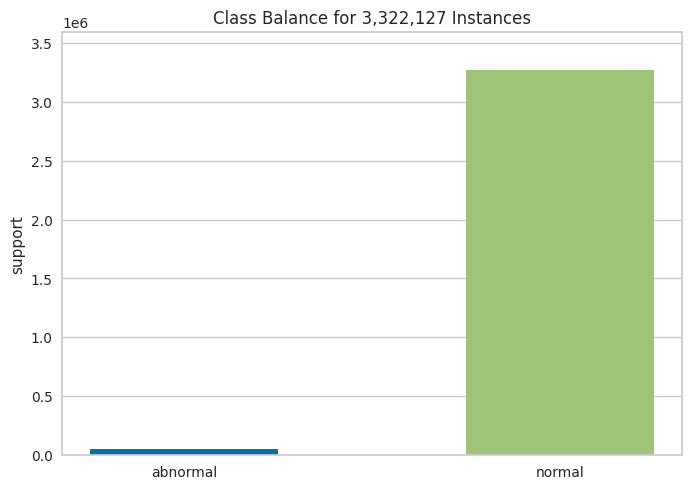

ClassBalance(ax=<Axes: title={'center': 'Class Balance for 3,322,127 Instances'}, ylabel='support'>)

In [9]:
# Plotting the class distributions for the full training data
class_balance(df['Target'])

From the above diagram it can be seen that the data is ***severely skewed***, which was expected as most time normal log are experienced more than abrnomal logs.<br>
Furthermore, due to the substantial size of the dataset containing approximately three million instances, conducting a comprehensive analysis would be time and compute intensive . To expedite computational processes, we will extract a representative subsample for the EDA continuation, allowing for a more manageable and efficient exploration. <br> 
In order to ensure a proportional representation of various categories within the dataset, we will employ the Stratified Sampling Technique. This method strategically selects samples from each category, preserving the distribution and enabling us to work with a well-rounded subset of the data.

In [10]:
X_train, _, Y_train, _ = train_test_split(df['Log'], df['Target'], random_state= 23, test_size=0.75,
                                                    stratify=df['Target'])
print(f" After stratified sampling method, {X_train.shape[0]}")

 After stratidied sampling method, 830531


In [11]:
df = pd.DataFrame()
df['Log'] = X_train
df['Target'] = Y_train
df.reset_index(inplace=True)
df.drop(['index'], axis = 1,inplace= True)
df.head()

,Log,Target
0,1122147236 2005.07.23 R00-M1-N6-C:J08-U11 200...,normal
1,1120092051 2005.06.29 R04-M0-NE-C:J10-U11 200...,normal
2,1120917289 2005.07.09 R12-M1-N3-C:J10-U01 200...,normal
3,1120146573 2005.06.30 R00-M0-N5-C:J07-U01 200...,normal
4,1118773076 2005.06.14 R21-M1-N9-C:J15-U11 200...,normal


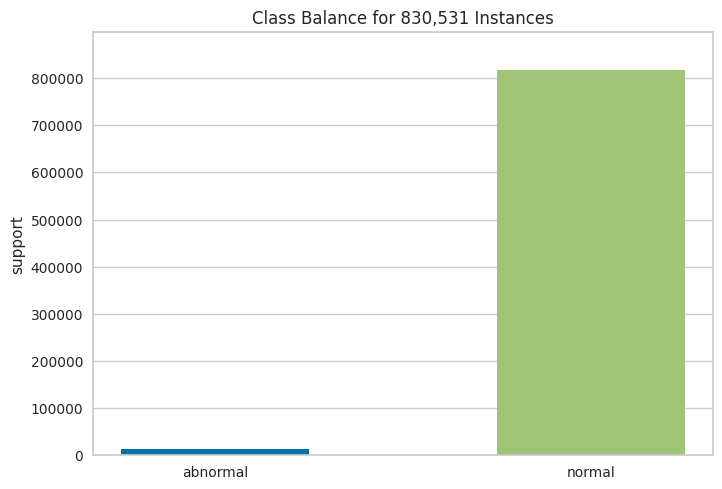

ClassBalance(ax=<Axes: title={'center': 'Class Balance for 830,531 Instances'}, ylabel='support'>)

In [12]:
# Sample class Distribtution
class_balance(df['Target'])

<a id="ch3"></a>
### Step 3 - Decoding Textual Patterns: Statistical Analysis
Text statistics analysis and visualizations encompass straightforward yet remarkably insightful methodologies that provide a profound understanding of the underlying text data. These techniques include word frequency analysis, sentence length analysis, and average word length analysis, all of which collectively contribute to unraveling the fundamental characteristics embedded within the textual content.<br>

Character and Sentence length analysis, on the other hand, examines the distribution of sentence lengths across the dataset. This exploration aids in gauging the complexity of the text and its overall readability. By understanding the variation in sentence lengths, we can assess the pacing and structure of the content, offering insights into the log text.<br>

Average word length analysis provides additional granularity by calculating the average number of characters per word in the log text. This metric can offer insights into the text's level of technicality, formality, or even the language it is composed in.<br>

Collectively, these text statistics analysis and visualizations serve as foundational tools for comprehending the nuances of textual data. They empower researchers and analysts to unearth valuable patterns, trends, and hidden information, enabling a more informed and data-driven approach to subsequent analyses and modeling.

In [13]:
#Generating the Character length and Average word length
df["Character_Length"] = df["Log"].str.len()
df["Word_Length"] = df["Log"].str.split().map(lambda x: len(x))
df["Avg Word"] = df["Log"].str.split().apply(lambda x: [len(i) for i in x]).map(lambda x: np.mean(x))
df.head()

,Log,Target,Character_Length,Word_Length,Avg Word
0,1122147236 2005.07.23 R00-M1-N6-C:J08-U11 200...,normal,145,13,10.076923
1,1120092051 2005.06.29 R04-M0-NE-C:J10-U11 200...,normal,127,10,11.600000
2,1120917289 2005.07.09 R12-M1-N3-C:J10-U01 200...,normal,127,10,11.600000
3,1120146573 2005.06.30 R00-M0-N5-C:J07-U01 200...,normal,126,10,11.500000
4,1118773076 2005.06.14 R21-M1-N9-C:J15-U11 200...,normal,143,14,9.142857


In [14]:
print(f"Character Length ranges from {df['Character_Length'].min()} to {df['Character_Length'].max()} over the text corpus")
print(f"Word Length ranges from {df['Word_Length'].min()} to {df['Word_Length'].max()} over the text corpus")

Character Length ranges from 94 to 928 over the text corpus
Word Length ranges from 8 to 101 over the text corpus


In [15]:
print(f"Maximum character length is {df['Character_Length'].max()} and Minimum charater length is {df['Character_Length'].min()} over the text corpus")
print(f"Maximum word length is {df['Word_Length'].max()} and Minimum word length is {df['Word_Length'].min()} over the text corpus")

Maximum character length is 928 and Minimum charater length is 94 over the text corpus
Maximum word length is 101 and Minimum word length is 8 over the text corpus


Creating histogram diagrams to visualize the distribution of character lengths and word lengths provides a clear and insightful perspective into the textual data. These visualizations offer a comprehensive overview of the variations in text composition, shedding light on key characteristics that might otherwise remain unnoticed

array([[<Axes: title={'center': 'Character_Length'}>,
        <Axes: title={'center': 'Word_Length'}>]], dtype=object)

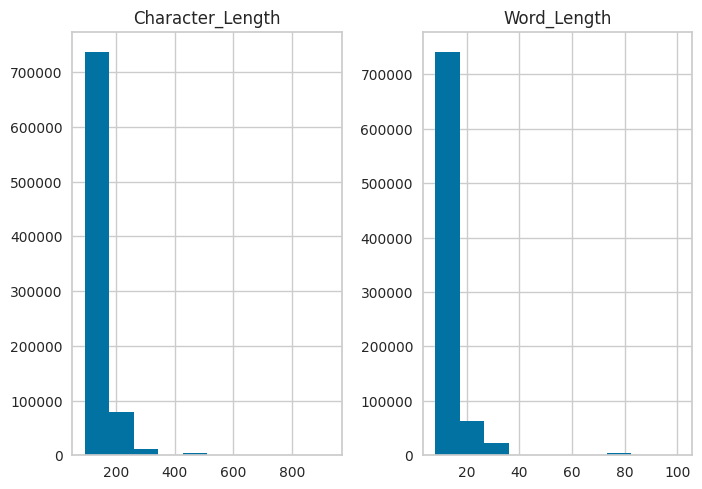

In [16]:
cleaned_stats_columns = ['Character_Length', 'Word_Length']
df.hist(column=cleaned_stats_columns, grid=True)

It could be seen that marjority of log text have charatcer length of and word length of 

<a id="ch4"></a>
### Step 4 - Uncovering Language Patterns: Word Frequ Stopwords and N-grams




Word frequency analysis delves into the occurrences of individual words throughout the text, allowing us to identify dominant terms, common themes, and potentially significant keywords. This analysis provides valuable insights into the core themes and word relationship present within the text corpus, shedding light on its primary focus.<br>


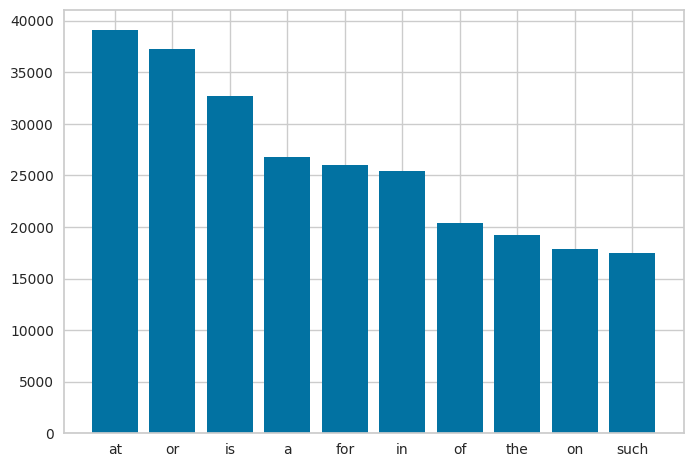

In [17]:
plot_top_stopwords_barchart(df['Log'])

From the chart above, it could been seen that the stop-words make a large part of the text corpus. Stop words are commonly occurring words in a language that are often filtered out during text analysis due to their limited contribution to the overall meaning of a sentence or document.<br>
These words, such as "the", "is" ,"at" and "in" hold minimal informational value and are used to connect meaningful words. While essential for grammar and sentence structure, stop words provide little relevance and usefulness when trying to identify significant patterns, themes, or topics within a text. Therefore, excluding them helps focus the analysis on the more meaningful and informative content, enhancing the accuracy and interpretability of the results.<br>

In [18]:
df['Log'] = df['Log'].apply(clean_text_data)
df["Cleaned_Character_Length"] = df["Log"].str.len()
df["Cleaned_Word_Length"] = df["Log"].str.split().map(lambda x: len(x))
df["Cleaned_Avg Word"] = df["Log"].str.split().apply(lambda x: [len(i) for i in x]).map(lambda x: np.mean(x))
df.head()

,Log,Target,Character_Length,Word_Length,Avg Word,Cleaned_Character_Length,Cleaned_Word_Length,Cleaned_Avg Word
0,rmncju rmncju ras kernel info floating point a...,normal,145,13,10.076923,65,9,6.333333
1,rmnecju rmnecju ras kernel info generating core,normal,127,10,11.600000,47,7,5.857143
2,rmncju rmncju ras kernel info generating core,normal,127,10,11.600000,45,7,5.571429
3,rmncju rmncju ras kernel info generating core,normal,126,10,11.500000,45,7,5.571429
4,rmncju rmncju ras kernel fatal floating pt ex ...,normal,143,14,9.142857,57,10,4.800000


In [19]:
print(f"Character Length ranges from {df['Cleaned_Character_Length'].min()} to {df['Cleaned_Character_Length'].max()}")
print(f"Word Length ranges from {df['Cleaned_Word_Length'].min()} to {df['Cleaned_Word_Length'].max()}")
print(f"Maximum character length is {df['Character_Length'].max()} and Minimum charater length is {df['Character_Length'].min()}")
print(f"Maximum word length is {df['Word_Length'].max()} and Minimum word length is {df['Word_Length'].min()}")

Character Length ranges from 29 to 648
Word Length ranges from 5 to 56
Maximum character length is 928 and Minimum charater length is 94
Maximum word length is 101 and Minimum word length is 8


array([[<Axes: title={'center': 'Cleaned_Character_Length'}>,
        <Axes: title={'center': 'Cleaned_Word_Length'}>]], dtype=object)

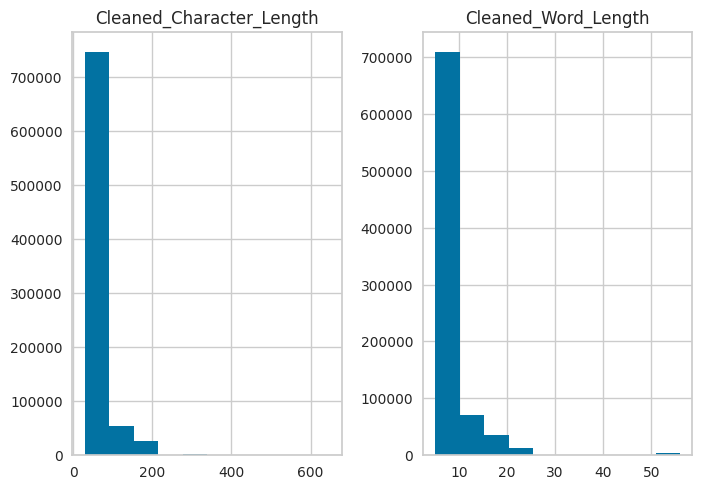

In [20]:
cleaned_stats_columns = ['Cleaned_Character_Length', 'Cleaned_Word_Length']
df.hist(column=cleaned_stats_columns, grid=True)

Examining the most frequent n-grams can provide a richer understanding of the contextual usage of words within a text. N-grams are contiguous sequences of n items, typically words in the case of text analysis. By analyzing and visualizing the top n-grams through a bar chart, one can gain insights into the specific phrases and word combinations that frequently co-occur.<br>

This approach offers a more nuanced view of how words are utilized within their surrounding context. N-grams capture not only single words but also reveal patterns of language usage, idiomatic expressions, and specific syntactical structures. Plotting a top n-gram bar chart showcases these recurring phrases, shedding light on the ways in which words interact and contribute to the overall meaning.<br>

In essence, investigating prominent n-grams enables a deeper exploration of the intricate relationships between words. This analysis is particularly valuable for capturing nuances, disambiguating word meanings, and grasping the subtle shifts in language usage that might go unnoticed when examining isolated words. As a result, it contributes to a more holistic and accurate interpretation of the text's content and intention.

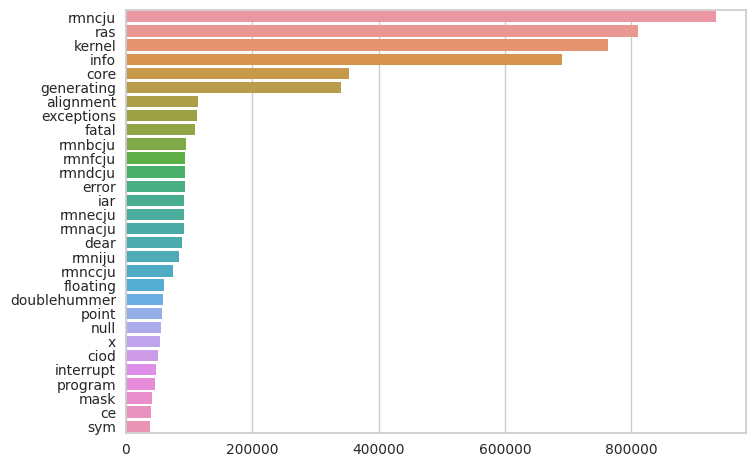

In [23]:
plot_top_word_barchart(df['Log'])

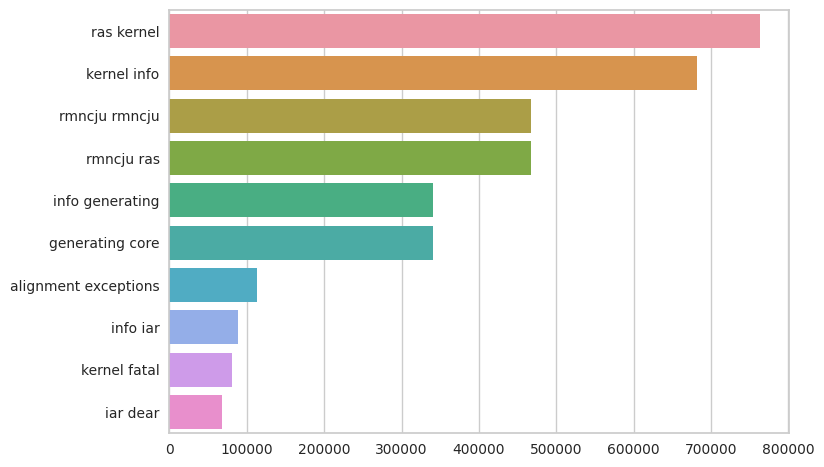

In [22]:
plot_top_ngrams_words_barchart(df['Log'])

In [ ]:
plot_top_ngrams_words_barchart(df['Log'],no_grams= 3)

<a id="ch6"></a>

### Conclusion - Key Objective and Takeaway

text